# Analysis and curation of [cxr14](https://nihcc.app.box.com/v/ChestXray-NIHCC) dataset

The dataset consists of x-ray images of patients and the labels are the conditions that are present on the patient.

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
import seaborn as sns


In [2]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']
labels.sort()
print(labels)

#read the whole dataset
df = pd.read_csv("dataset/Data_Entry_2017_v2020.csv")

df_count = (df.groupby('Patient ID')
         .agg({'Patient ID' : 'count'})
         .rename(columns={'Patient ID':'count'}))

print('Total entries:',len(df.index))
print('No of patients:',df_count.query('count > 1').shape[0])
df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Total entries: 112120
No of patients: 13302


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


There are 112120 total x-ray entries of 13302 patients
We observe that there exists only a single label where the conditions are words delimited with a character (|). This representation is not easily comprehended as code. We will have to transform this to one column per label when we will actually use the dataset.

We then depict each condition's frequency both without and with xrays that showed no condition:

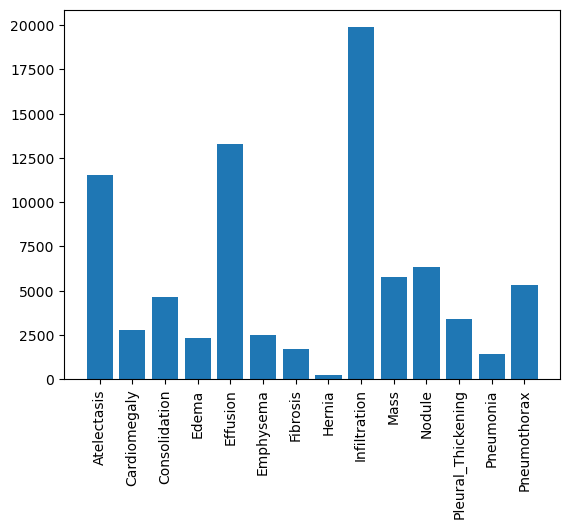

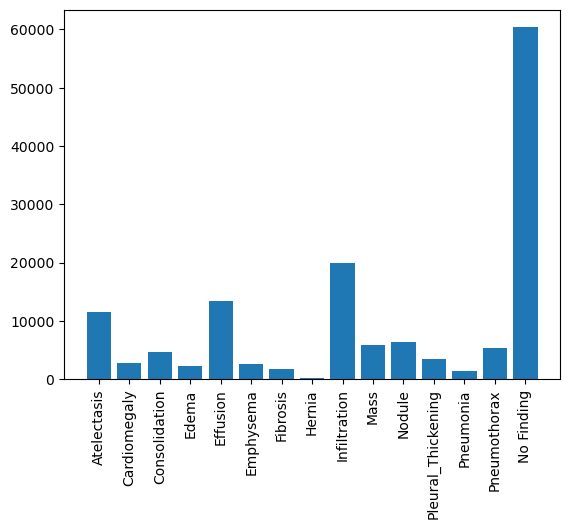

In [3]:
def get_freq(labels,df,col):
    freq={}
    for l in labels:
        for f in df[col] :
            if l in f:
                freq[l] = freq[l] + 1 if (l in freq) else 0
    return freq

def plot_freq_old(labels,df,col):
    fig, ax = plt.subplots()
    freq=get_freq(labels,df,col)
    
    plt.bar(*zip(*freq.items()))
    plt.xticks(rotation='vertical')
    plt.show()
    return freq
frequencies = plot_freq_old(labels,df,'Finding Labels')
frequencies_with_no_condition = plot_freq_old(labels + ['No Finding'],df,'Finding Labels')

We observe that Infiltration, Effusion and Atelectasis are the conditions that occur the most. Moreover a substatial amount of x-rays depict people that don't have any of the conditions. To get a better look we will plot the same graphs but with a percentage of the total entries:

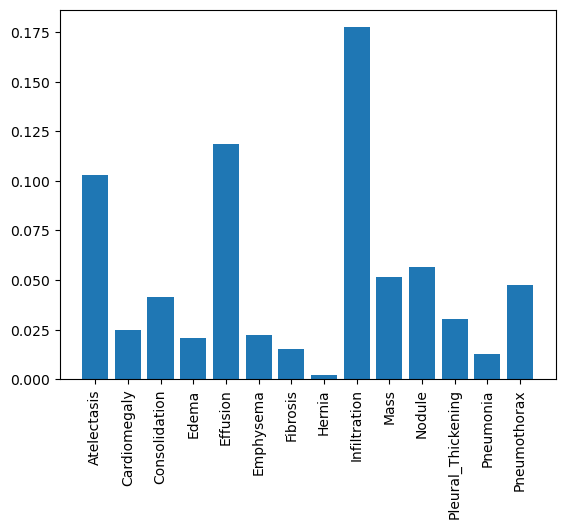

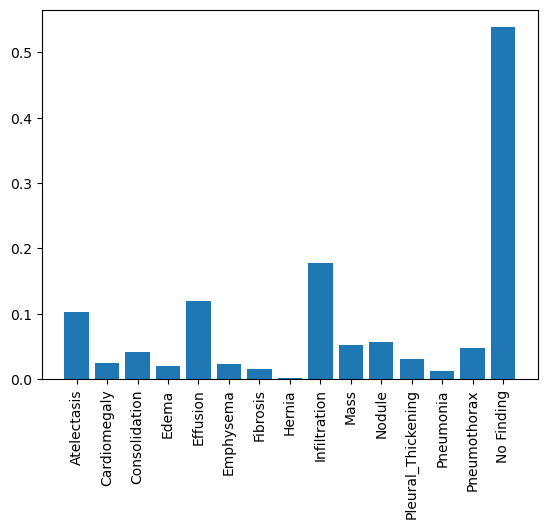

In [4]:
def plot_freq_old_perc(labels,df,col):
    fig, ax = plt.subplots()
    freq=get_freq(labels,df,col)
    total = df.shape[0]
    for key in freq:
       freq[key]/=total
    
    plt.bar(*zip(*freq.items()))
    plt.xticks(rotation='vertical')
    plt.show()
    return freq
frequency_perk = plot_freq_old_perc(labels,df,'Finding Labels')
frequency_perk_with_no_condition = plot_freq_old_perc(labels + ['No Finding'],df,'Finding Labels')

Infiltration is ~20%, Effusion and Atelectasis ~10% and a stagering ~50% of the xrays depict no condition

The labels being delimited with '|' is quite inconvenient. To fix this we create new columns one for each condition that are either 1 or 0 depending on their precense or not. This is done as follows:

In [5]:
for label in labels:
    df[label] = df['Finding Labels'].map(lambda res: 1 if label in res else 0)

df.drop('Finding Labels', axis=1, inplace=True)
df.head()


,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,0,1,57,M,PA,2682,2749,0.143,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,58,M,PA,2894,2729,0.143,0.143,...,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,2,1,58,M,PA,2500,2048,0.168,0.168,...,1,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,2,80,M,PA,2500,2048,0.171,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_001.png,0,3,74,F,PA,2500,2048,0.168,0.168,...,0,0,0,1,0,0,0,0,0,0


Now let's explore the non image features of the dataset.


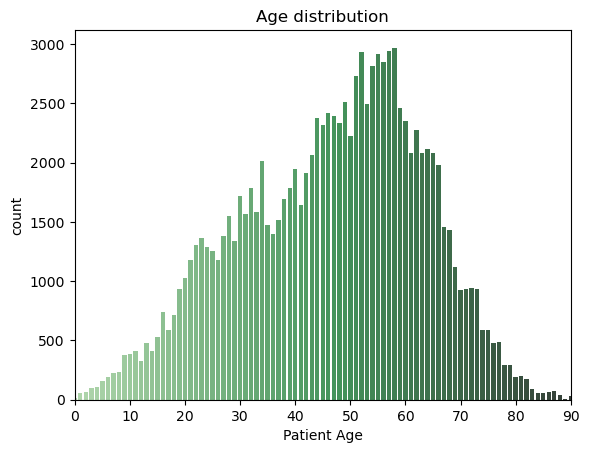

In [42]:
plot = sns.countplot(x='Patient Age',data=df, palette="Greens_d")
plot.set_xlim(0,90)
plot.set(title='Age distribution');
x = np.arange(0,100,10)
plot.set_xticks(x)
plot.set_xticklabels(x);



Some patients tend to have follow ups. Let's observe how many.

Text(0.5, 1.0, 'Follow-up distribution')

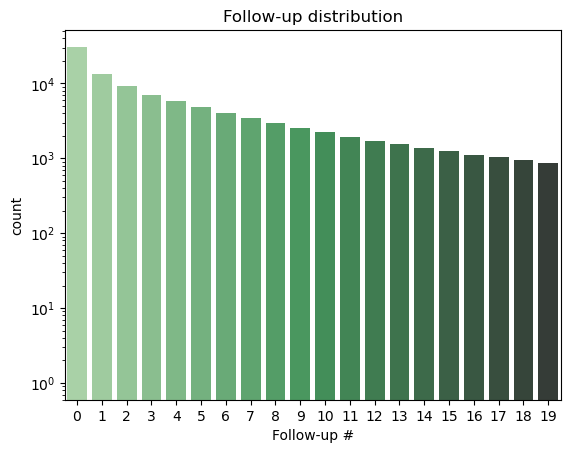

In [47]:
plot = sns.countplot(x='Follow-up #',data=df, order = pd.value_counts(df['Follow-up #']).index, palette="Greens_d")
plot.set_title('Follow-up distribution')
plot.set_yscale("log")

plot = sns.countplot(x='Follow-up #',data=df, order = pd.value_counts(df['Follow-up #']).iloc[:20].index, palette="Greens_d")
plot.set_title('Follow-up distribution')